In [6]:
import numpy as np

from dataset_loader import load_from_file
from tabulate import tabulate
from matplotlib.pyplot import figure, imshow, axis
from commons import *
from skimage import data, util
from skimage.measure import label, regionprops
from scipy.ndimage import rotate
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line
from skimage import data
from skimage.transform import probabilistic_hough_line
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm

# obrót do poziomu, metodami:
# 1. hough lines
# 2. tomkowe
# 3. tamtą pierwszą biblioteką od eliciticy
# informacja wzjaemna - między jednym obrazkiem a porównywanym
# jeszcze te metryki: https://towardsdatascience.com/measuring-similarity-in-two-images-using-python-b72233eb53c6


DOTS_DST = 'cache/dots_v2.pickle'
TRACKS_DST = 'cache/tracks_v2.pickle'
WORMS_DST = 'cache/worms_v2.pickle'
ARTIFACTS_DST = 'cache/artifacts_v2.pickle'

DOTS_DSTx4 = 'cache/dots_v3.pickle'
TRACKS_DSTx4 = 'cache/tracks_v3.pickle'
WORMS_DSTx4 = 'cache/worms_v3.pickle'
ARTIFACTS_DSTx4 = 'cache/artifacts_v3.pickle'


tf_classes = [ tf.keras.metrics.AUC,
    tf.keras.metrics.Accuracy,
    tf.keras.metrics.BinaryAccuracy,
    tf.keras.metrics.BinaryCrossentropy,
    tf.keras.metrics.BinaryIoU,
    tf.keras.metrics.CategoricalAccuracy,
    tf.keras.metrics.CategoricalCrossentropy,
    tf.keras.metrics.CategoricalHinge,
    tf.keras.metrics.CosineSimilarity,
    tf.keras.metrics.FalseNegatives,
    tf.keras.metrics.FalsePositives,
    tf.keras.metrics.Hinge,
    #tf.keras.metrics.IoU,
    tf.keras.metrics.KLDivergence,
    tf.keras.metrics.LogCoshError,
    tf.keras.metrics.Mean,
    tf.keras.metrics.MeanAbsoluteError,
    tf.keras.metrics.MeanAbsolutePercentageError,
    #tf.keras.metrics.MeanIoU,
    #tf.keras.metrics.MeanMetricWrapper,
    #tf.keras.metrics.MeanRelativeError,
    tf.keras.metrics.MeanSquaredError,
    tf.keras.metrics.MeanSquaredLogarithmicError,
    #tf.keras.metrics.MeanTensor,
    #tf.keras.metrics.Metric,
    #tf.keras.metrics.OneHotIoU,
    #tf.keras.metrics.OneHotMeanIoU,
    tf.keras.metrics.Poisson,
    tf.keras.metrics.Precision,
    #tf.keras.metrics.PrecisionAtRecall,
    tf.keras.metrics.Recall,
    #tf.keras.metrics.RecallAtPrecision,
    tf.keras.metrics.RootMeanSquaredError,
    #tf.keras.metrics.SensitivityAtSpecificity,
    tf.keras.metrics.SparseCategoricalAccuracy,
    tf.keras.metrics.SparseCategoricalCrossentropy,
    tf.keras.metrics.SparseTopKCategoricalAccuracy,
    #tf.keras.metrics.SpecificityAtSensitivity,
    tf.keras.metrics.SquaredHinge,
    tf.keras.metrics.Sum,
    tf.keras.metrics.TopKCategoricalAccuracy,
    tf.keras.metrics.TrueNegatives,
    tf.keras.metrics.TruePositives ]

def generic_tf_metrics(cls):
    def tf_metrics(image, recon):
        m = cls()
        m.update_state(image, recon)
        return m.result().numpy()
    return tf_metrics, cls.__name__

tf_mean = generic_tf_metrics(tf.keras.metrics.Mean)


def tf_kl_divergence(image, recon):
    m = tf.keras.metrics.KLDivergence()
    m.update_state(image, recon)
    return m.result().numpy()


def tf_accuracy(image, recon):
    m = tf.keras.metrics.Accuracy()
    m.update_state(image, recon)
    return m.result().numpy()

def tf_mse(image, recon):
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(image, recon)
    return m.result().numpy()




funcs = [
    (dm_func_mean2, 'mean'),
    (dm_func_avg_hash, 'avg_hash'),
    (dm_func_p_hash, 'p_hash'),
    (dm_func_d_hash,  'd_hash'),
    (dm_func_haar_hash,  'haar_hash'),
    (dm_func_db4_hash, 'db4_hash')
] #, tf_kl_divergence, tf_accuracy, tf_mse]
for c in tf_classes:
    funcs.append(generic_tf_metrics(c))


def angle(x, y):
    rad = np.arctan2(y, x)
    degrees = rad*180/np.pi
    return degrees


def round_normalize(image):

    #label_img = np.where(image > 0, 1, 0)
    #label_img = label(img, connectivity=img.ndim)
    #props = regionprops(label_img)

    #edges = canny(image, 2, 1, 25)
    lines = probabilistic_hough_line(image, threshold=10, line_length=5, line_gap=3)
    angles = []
    for l in lines:
        vector_1 = [l[1][1] - l[0][1], l[1][0] - l[0][0]]
        print(vector_1)
        angles.append(angle(l[1][0] - l[0][0], l[1][1] - l[0][1]))
    deg = np.average(angles) if len(angles) else 0
    print(deg)
    print("")

    mask = np.where(image == 0, 0.0, 1.0)
    rotated_mask = rotate(mask, deg, reshape=False)
    rotated_image = rotate(image, deg, reshape=False)
    rotated_image = np.where(rotated_mask < 0.25, 0, rotated_image)
    rotated_image = np.where(rotated_image < 0, 0, rotated_image)
    rotated_image = np.where(rotated_image > 1, 1, rotated_image)
    rotated_image.sort(axis=0)
    return rotated_image


def showImagesMatrix(images, col=10):

    hSize = 20
    wSize = 20

    fig = figure( figsize=(wSize, hSize))
    number_of_files = len(images)
    row = number_of_files // col
    if (number_of_files%col != 0):
        row += 1

    row_head = ['Image 0 vs image:']
    row_funcs = []

    for f, n in funcs:
        row_funcs.append([n])

    img0 = round_normalize(images[0])
    img0 = np.expand_dims(img0, axis=-1)

    for i in range(number_of_files):
        row_head.append(str(i))
        a=fig.add_subplot(row,col,i+1)
        image = round_normalize(images[i])
        image = np.expand_dims(image, axis=-1)
        imshow(image,cmap='Greys_r')
        axis('off')

        #print('%010s | %6.3f' % ('dm_func_mean2', v))
        for fi, (f, n) in enumerate(funcs):
            v = f(img0, image)
            row_funcs[fi].append(str(v))

    table = [row_head, *row_funcs]
    print(tabulate(table))



images, augmented = load_from_file(TRACKS_DST)
#showImagesMatrix([augmented[16], augmented[0], augmented[2], augmented[5], images[0]], 5)
#showImagesMatrix([images[0], images[1], images[2], images[3], images[4]], 5)

[-8, -8]
[-7, -7]
-135.0

[-8, -8]
[-7, -7]
-135.0

[-2, -10]
[-2, -10]
-168.6900675259798

[-8, 8]
[-7, 7]
-45.0

[-7, -7]
[-8, -8]
-135.0

[-7, 7]
[-7, 7]
-45.0

-----------------------------  -------------  ---------------  ---------------  ---------------  -------------
Image 0 vs image:                 0               1                2                3               4
mean                              0             -12.4729          -9.49468         -9.49468         0
avg_hash                          0               0                0                0               0
p_hash                            0               0                0.0604915        0.0604915       0
d_hash                            0               0                0                0               0
haar_hash                         0               0                0                0               0
db4_hash                          0               0.0926276        0.0113422        0.0113422       0
AUC        

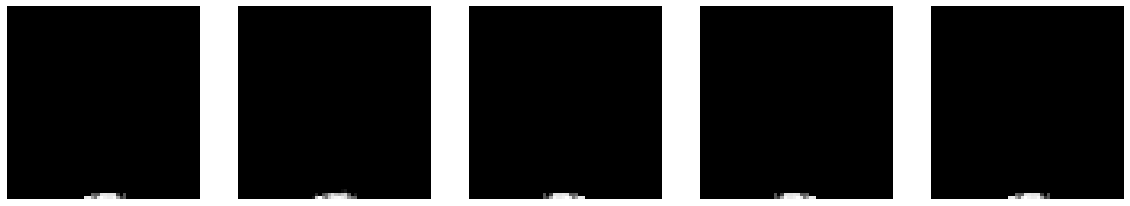

In [7]:
showImagesMatrix([images[0], augmented[0], augmented[2], augmented[5], augmented[16]], 5)

[-7, -7]
[-8, -8]
-135.0

[-7, -7]
[-8, -8]
-135.0

[-8, -2]
-104.0362434679265

[-4, -7]
-150.25511870305778

[-5, -5]
-135.0

[-9, -1]
[-6, -1]
-97.90125697696777

-----------------------------  -------------  ---------------  ---------------  ----------------  ----------------
Image 0 vs image:                 0               1                2                 3                 4
mean                              0              -9.44771         -9.87856          -8.54649          -7.85493
avg_hash                          0               0                0                 0.00189036        0.00189036
p_hash                            0               0                0                 0.0604915         0
d_hash                            0               0.00378072       0.00189036        0.00378072        0.00567108
haar_hash                         0               0.0453686        0.0453686         0.0245747         0.0453686
db4_hash                          0               0.05482

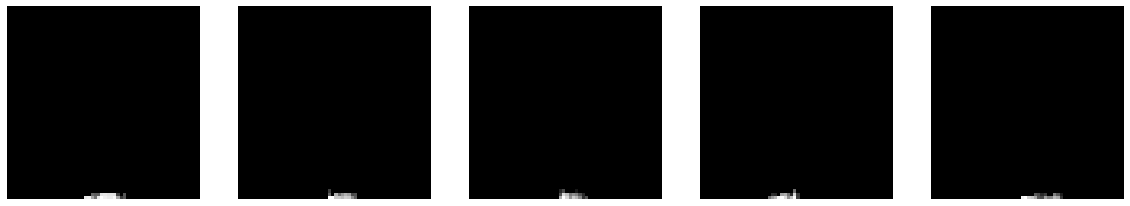

In [8]:
showImagesMatrix([images[0], images[1], images[2], images[3], images[4]], 5)

0

0

0

0

0

0

-----------------------------  --------------  ---------------  ---------------  ----------------  ----------------
Image 0 vs image:                 0                1                2                 3                 4
mean                              0               -6.53412         -8.28382          -2.68695          -2.68695
avg_hash                          0                0                0                 0                 0
p_hash                            0                0                0                 8                 8
d_hash                            0                0                0                 0                 0
haar_hash                         0                0.75             5.25              6                 6
db4_hash                          0                2                0.5               6.25              6.25
AUC                               1                1                0.749931          0.499722          0.499722
Ac

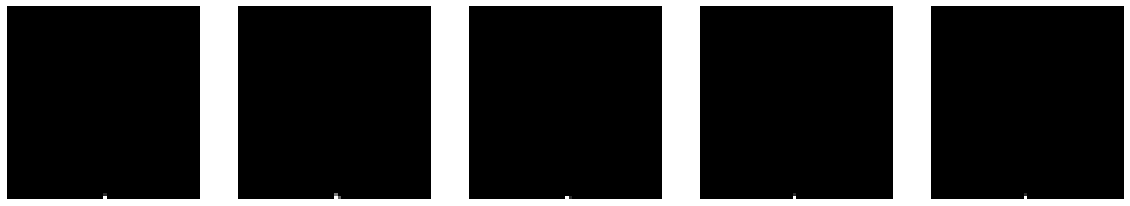

In [9]:
images_dots, augmented_dots = load_from_file(DOTS_DST)

showImagesMatrix([images_dots[0], augmented_dots[0], augmented_dots[2], augmented_dots[5], augmented_dots[16]], 5)

0

0

0

0

0

0

-----------------------------  --------------  ----------------  ----------------  ----------------  ----------------
Image 0 vs image:                 0                 1                 2                 3                 4
mean                              0                -3.55451          -4.05199          -1.53336          -1.65024
avg_hash                          0                 0                 0                 0                 0
p_hash                            0                 0                 0                 0                 0
d_hash                            0                 0                 0                 0                 0
haar_hash                         0                 3                 3                 1                 0.5
db4_hash                          0                 3.25              3.75              1                 3.25
AUC                               1                 0.999861          0.999861          0.999861 

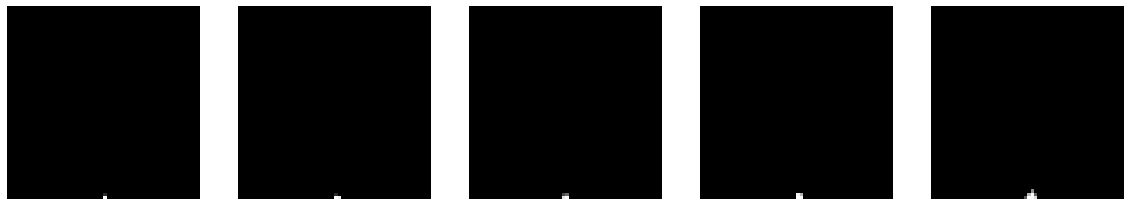

In [10]:
showImagesMatrix([images_dots[0], images_dots[1], images_dots[2], images_dots[3], images_dots[4]], 5)

[-5, -5]
[-8, 0]
[-5, 5]
[-5, 5]
-78.75

[-7, -1]
[-5, -5]
[-5, 5]
[-5, 5]
[-2, -7]
-97.43694129064663

[-8, 2]
[-5, -5]
[-7, -4]
[-5, -5]
[-5, -5]
[-5, 5]
[-5, -5]
-111.52980540414511

[-5, -5]
[-5, -5]
[-5, 5]
[-5, -5]
[-7, 1]
[-5, 5]
-96.144982940974

[-6, 3]
[-5, -5]
[-3, -6]
[-6, -2]
[-2, -5]
[-5, 5]
[-4, 5]
-100.30903503378634

[-5, 5]
[-5, -5]
[-5, -5]
[-6, 3]
-94.6087372057305

-----------------------------  ---------------  --------------  ----------------  --------------  ---------------
Image 0 vs image:                  0               1                 2               3                4
mean                             -13.8865        -18.207            -9.76593        -9.51705        -15.8188
avg_hash                           0.000287274     0                 0.000574548     0.000287274      0
p_hash                             0               0                 0.00919276      0.00919276       0
d_hash                             0.000287274     0                 0.00086

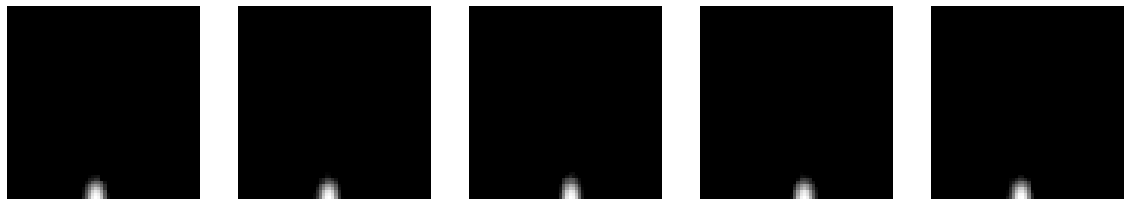

In [11]:
images_dots4x, augmented_dots4x = load_from_file(DOTS_DSTx4)
showImagesMatrix([images_dots4x[0], augmented_dots4x[0], augmented_dots4x[2], augmented_dots4x[5], augmented_dots4x[16]], 5)

[-2, -6]
[-5, -5]
[-7, 2]
[-7, 2]
[-2, -7]
[-3, -5]
-126.29418449037264

[-7, 2]
[-7, -1]
[-5, 5]
[-2, -7]
[-3, -6]
-106.93485187504646

[-6, 6]
[-4, -8]
[0, 9]
[-5, -5]
[-4, 9]
[-1, -5]
[-2, -9]
[-5, 5]
[-5, -5]
-97.06207751270317

[-5, -8]
[-7, 6]
[-7, 6]
[-6, -6]
[-7, -7]
[0, -5]
[-3, -5]
[-3, 6]
[-7, 4]
[-7, -7]
[-5, -5]
-76.60440371363362

[-10, 2]
[-10, -2]
[-5, 10]
[-6, 1]
[-9, -6]
[-1, -9]
[-7, -4]
[-5, -5]
[-8, -8]
[-6, 6]
[-7, -7]
[-8, 4]
-101.46936957241554

[-11, 11]
[-6, -6]
[-12, 12]
[-10, -5]
[-3, 7]
[-5, 14]
[-9, 4]
[-6, 2]
[-10, 10]
[-9, 9]
[-6, -2]
[-11, 11]
[-11, 11]
[-5, 3]
[-6, 6]
[-5, 5]
[-5, 1]
-61.069487515771044

-----------------------------  ---------------  ----------------  ----------------  --------------  --------------
Image 0 vs image:                  0                 1                 2               3               4
mean                             -15.8767          -10.4289          -10.858          -7.52842        -7.46306
avg_hash               

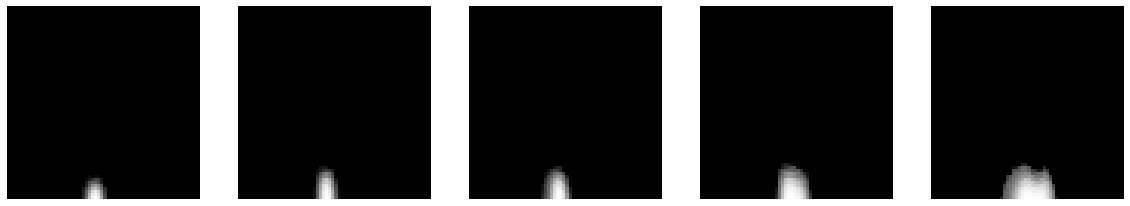

In [12]:
showImagesMatrix([images_dots4x[0], images_dots4x[1], images_dots4x[2], images_dots4x[3], images_dots4x[4]], 5)

[-3, 7]
[-2, 5]
-22.5

[-3, 7]
[-5, 5]
-34.09929525682409

[-7, 4]
[-7, 4]
-60.25511870305779

[-5, -5]
[-5, -3]
-127.98187826603676

[-6, 4]
[-5, 6]
-48.057751783142706

[-5, -5]
[-5, -5]
-135.0

-----------------------------  ---------------  ---------------  ---------------  ----------------  ----------------
Image 0 vs image:                  0                1                2                 3                 4
mean                             -12.7935         -13.4236         -12.5103           -9.49768         -11.8322
avg_hash                           0                0                0                 0                 0
p_hash                             0                0                0                 0.0355556         0
d_hash                             0                0                0                 0.00111111        0
haar_hash                          0.00333333       0.00222222       0.00444444        0.0288889         0.0177778
db4_hash                       

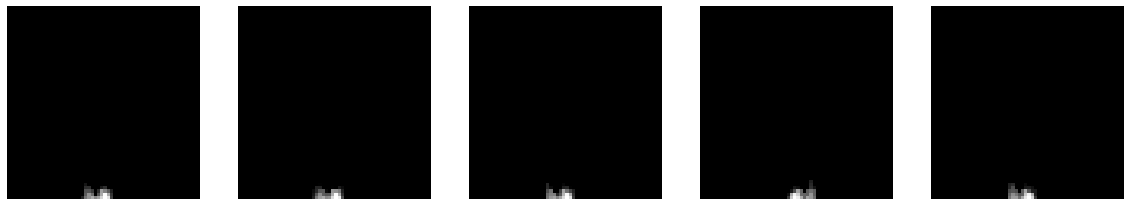

In [13]:
images_worms, augmented_worms = load_from_file(WORMS_DST)
showImagesMatrix([images_worms[0], augmented_worms[0], augmented_worms[2], augmented_worms[5], augmented_worms[16]], 5)

[-3, 7]
[-5, 5]
-34.09929525682409

[-5, 5]
[-3, 7]
-34.09929525682409

[-3, -5]
-149.03624346792648

[-5, 7]
[-2, 5]
[-7, 6]
[-9, 7]
[-7, 6]
-41.652302867443815

0

0

-----------------------------  -------------  ---------------  --------------  ----------------  ----------------
Image 0 vs image:                 0               1               2                 3                 4
mean                              0             -10.6389         -7.32326          -8.30798          -7.47788
avg_hash                          0               0.00104058      0.00312175        0.00104058        0.00312175
p_hash                            0               0               0                 0.0332986         0
d_hash                            0               0               0.00312175        0.00312175        0
haar_hash                         0               0.00936524      0.00936524        0.0166493         0.00312175
db4_hash                          0               0.0395421       0.0

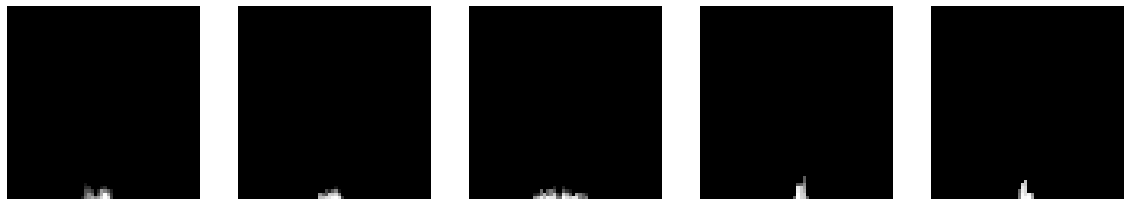

In [14]:
showImagesMatrix([images_worms[0], images_worms[1], images_worms[2], images_worms[3], images_worms[4]], 5)

[-8, -8]
[-7, -7]
-135.0

[-8, -8]
-135.0

[-5, 5]
[-5, 5]
-45.0

0

[-6, 4]
[-5, 4]
[-2, 6]
[-6, 2]
-49.41253105498253

-----------------------------  -------------  ----------------  --------------  --------------
Image 0 vs image:                 0                1               2               3
mean                              0               -8.93626        -8.04446        -7.80698
avg_hash                          0                0               0               0.00378072
p_hash                            0                0.0604915       0               0.0604915
d_hash                            0                0               0.00378072      0.00189036
haar_hash                         0                0.0340265       0.0226843       0.0453686
db4_hash                          0                0.047259        0.047259        0.073724
AUC                               1                0.846586        0.543478        0.865949
Accuracy                          1               

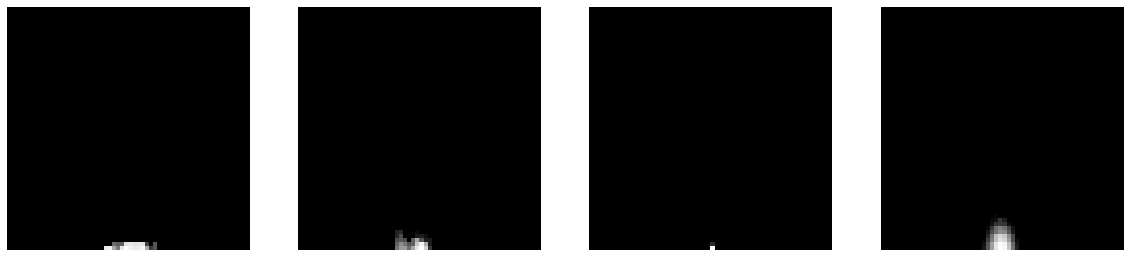

In [15]:
showImagesMatrix([images[0], images_worms[0], images_dots[0], images_dots4x[0][2:62,2:62]], 4)